# Приклад використання мультиагентної PLM-системи різьбових з'єднань
Розподілена МАС створена на основі концепції акторів і Python Ray. Кожен агент (актор) може виконуватись паралельно разом з іншими агентами. Можна організувати автоматичну роботу системи за допомогою простого алгоритму: виконувати функцію rule кожного агента, поки ці функції повертають якісь значення, що не рівні None. В даному прикладі це реалізовано для логічного виведення нових фактів з бази існуючих фактів і правил логічного виведення.

Передусім потрібно ініціалізувати систему ray. В даному прикладі використовуються виключно ресурси одного комп'ютера, але можна використати і кластер.

In [1]:
import ray
ray.init()

D:\Portable\Portable Python-3.8.9 x64\App\Python\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': 'tcp://127.0.0.1:62637',
 'raylet_socket_name': 'tcp://127.0.0.1:59891',
 'webui_url': None,
 'session_dir': 'D:\\Temp\\ray\\session_2022-01-29_17-08-11_601396_8612',
 'metrics_export_port': 60824,
 'node_id': 'c5c7e232bd0f61c044d8f05aebb9dff1508efedfec1f87ddcd971c3e'}

## Клас акторів Fact
Клас описує поняття факту у вигляді триплету (суб'єкт, предикат, об'єкт). Функція rule повертає кортеж триплету.

In [2]:
@ray.remote
class Fact(object):
    def __init__(self,s,p,o):
        self.s, self.p, self.o = s, p, o
    def rule(self):
        return self.s, self.p, self.o

## Клас акторів Rule1
Клас описує поняття правила логічного виведення для симетричної властивості p: (1, p, 3)->(3, p, 1). Для пришвидшення алгоритму використовується техніка мемоїзації - в атрибуті ready зберігаються оброблені триплети. Однократно обробляється множина триплетів ts. Повертається множина нових триплетів.

In [3]:
@ray.remote
class Rule1(object):
    def __init__(self,p):
        self.p = p
        self.ready=set()
    def rule(self, ts=None):
        """"Симетрична властивість 2: (1, 2, 3)->(3, 2, 1)"""
        tn=set()
        for s,p,o in ts:
            if self.p!=p: continue
            if (s,p,o) in self.ready: continue
            self.ready.add((s,p,o))
            self.ready.add((o,p,s))
            tn.add((o,p,s))
        return tn

## Клас акторів Rule2
Клас описує поняття правила логічного виведення для транзитивної властивості p: (1, p, 3)&(3, p, 4)->(1, p, 4). Однократно обробляється множина триплетів ts. Повертається множина нових триплетів. Для пришвидшення алгоритму можна використати техніку мемоїзації і зберігати множину оброблених триплетів в ready. З множини ts можна буде вилучити ready.

In [4]:
@ray.remote
class Rule2(object):
    def __init__(self,p):
        self.p = p
        self.ready=set()
    def rule(self, ts=None):
        """"Транзитивна властивість 2: (1, 2, 3)&(3, 2, 4)->(1, 2, 4)"""
        tn=set()
        X=set()
        for s,p,o in ts:
            if self.p!=p: continue
            X.add((s,p,o))
            for sx,px,ox in X:
                if (ox==s and sx!=o):
                    if (sx,p,o) in self.ready: continue
                    tn.add((sx,p,o))
                    self.ready.add((sx,p,o))
                elif (sx==o and ox!=s):
                    if (s,p,ox) in self.ready: continue
                    tn.add((s,p,ox))
                    self.ready.add((s,p,ox))
        return tn

## Клас акторів Reasoner

Клас описує поняття машини логічного виведення. Функція rule запускає ОДНОКРАТНО паралельно правила агентів rs, яким передаються триплети з фактами ts. Функція повертає множину триплетів з новими фактами. Аналогічно є можливість використати техніку мемоїзації, але це в класі не реалізовано.

In [5]:
@ray.remote
class Reasoner(object):
    def __init__(self):
        self.ready=set()
    def triplets(self, fs):
        refs=[f.rule.remote() for f in fs]
        ts=ray.get(refs)
        return ts
    def rule(self, rs, ts):
        refs=[r.rule.remote(ts) for r in rs] # запустити паралельно
        T=ray.get(refs) # список множин триплетів
        r=set()
        for t in T:
            r.update(t)
        return r

## Клас акторів FEA
Клас описує поняття FEA системи для скінченно-елементної симуляції моделі різьбового з'єднання. Для моделювання використовується pycalculix. Функція rule отримує параметр з'єднання x і повертає максимальне напруження. Для мемоїзації використовується словник ready.

In [6]:
@ray.remote
class FEA(object):
    def __init__(self):
        self.ready=dict()
    def rule(self, x=0.1):
        #if x in self.ready: return None
        import mypycalculix
        mypycalculix.show_gui = False
        mypycalculix.hh=x
        s=mypycalculix.run()
        self.ready[x]=s
        return s

## Клас акторів CAM
Клас описує поняття CAM системи для генерації G-коду для фрезерування різьби ніпеля на 3-осьовому фрезерному верстаті з ЧПК. Функція rule отримує параметр з'єднання x і повертає відповідний список опорних точок G-коду. Для мемоїзації використовується атрибут ready.

In [7]:
@ray.remote
class CAM(object):
    def __init__(self):
        self.ready=dict()
    def rule(self, x=0.1):
        #if x in self.ready: return None
        import CNC_thread_mill
        rf=CNC_thread_mill.rf=10 # радіус фрези (0, якщо система ЧПК має команди корекції)
        # товщина фрези 0.5 мм
        # перші два проходи - примірочний r=10 і остаточний для 1-ї точки профілю
        P=CNC_thread_mill.TreadMulti(R=[10+rf, 9.5+x+rf], Z=[0, 0],  h=14, p=2, fi=0, n=64)
        code=CNC_thread_mill.Gcode(P, "cnc.txt") # код, зберегти у файл
        self.ready[x]=P
        return P

# Клас акторів SCADA

Клас описує поняття SCADA системи для моніторингу технічного стану різьбового з'єднання. Для вимірювання деформацій використовується тензодатчик, Arduino UNO, мікросхема HX711 та пакет pyserial. Функція rule отримує параметр з'єднання x і повертає залежність деформацій від часу роботи.

In [8]:
@ray.remote
class SCADA(object):
    def __init__(self):
        self.ready=dict()
    def rule(self, x=0.1):
        #if x in self.ready: return None
        import HX711proteus_client
        X,Y=HX711proteus_client.run()
        self.ready[x]=X,Y
        return X,Y

## Створення агентів системи (акторів)
Кожен агент може працювати паралельно з іншими. Проте це залежить від кількості процесорів на кластері. В даному випадку введені факти, які містять відповідність значень вхідних і вихідних параметрів моделі різьбового з'єднання: геометричного параметра h (мм), максимального еквівалентного напруження в різьбі Seqv (МПа), максимального сумарного переміщення utot (мм). Ці факти можуть бути отримані в результаті моделювання, експериментів, промислових даних на попередніх етапах ЖЦ.

In [9]:
f1=Fact.remote("Seqv=14", "відповідає", "h=0.1")
f2=Fact.remote("h=0.1", "відповідає", "utot=869e-6")
f3=Fact.remote("h=0.2", "відповідає", "Seqv=16")
r1=Rule1.remote("відповідає")
r2=Rule2.remote("відповідає")
r=Reasoner.remote()
fea1=FEA.remote()
cam1=CAM.remote()
scada1=SCADA.remote()

## Логічне виведення фактів
Функція rule агентів, які містять правила, викликається до тих пір, поки є результати (нові факти). Виводяться триплети з новими фактами. Ці тріплети можна використати для створення нових агентів-фактів.

In [10]:
fs=[f1, f2, f3]
rs=[r1, r2]
T=set()
re=1
while re:
    re=0
    ts=ray.get(r.triplets.remote(fs))
    tn=ray.get(r.rule.remote(rs, ts))
    if tn:
        T.update(tn)
        re+=1
print(T)

{('Seqv=16', 'відповідає', 'h=0.2'), ('Seqv=14', 'відповідає', 'utot=869e-6'), ('h=0.1', 'відповідає', 'Seqv=14'), ('utot=869e-6', 'відповідає', 'h=0.1')}


## FE-симуляція
За допомогою агента fea1 виконується симуляція різьбового з'єднання з параметром h=0,1 мм (зазор в різьбі). Відразу очікуємо результату. Але є можливість запустити симуляцію асинхронно ro=fea1.rule.remote(0.1) і отримати результат в комірках нижче y1=ray.get(ro).

In [11]:
%%capture
y1=ray.get(fea1.rule.remote(0.1))

Виведення результатів симуляції. Максимальне еквівалентне напруження за Мізесом (Па):

In [12]:
y1

14367274.322702967

Агент fea1 (за допомогою pycalculix) зберігає результати в робочому каталозі в рисунках png. Ці рисунки відображаються тут за допомогою Markdown розмітки `![name.png](name.png)`.

Сумарні деформації (мм):

![thread_utot.png](thread_utot.png)

Еквівалентні напруження Мізеса (Па):

![thread_Seqv.png](thread_Seqv.png)

## Генерація G-коду для фрезерування різьби
Генерація G-коду для фрезерування зовнішньої різьби з параметром h=0,1 мм відбувається за допомогою агента cam1. Відразу очікуємо результату. Але є можливість запустити симуляцію асинхронно ro=cam1.rule.remote(0.1) і отримати результат в комірках нижче y1=ray.get(ro).

In [13]:
y2=ray.get(cam1.rule.remote(0.1))

 pid=4356) File thread_utot.png was saved.


Перші опорні точки згенерованої траєкторії:

In [14]:
y2[0:5]

[(30, 0, 0),
 (20.0, -0.0, 0.0),
 (19.90326350260106, -1.9647142148487098, 0.03131991051454139),
 (19.613989805397143, -3.9104224725439822, 0.06263982102908278),
 (19.13497724081396, -5.818302672904855, 0.09395973154362416)]

Візуалізація опорних точок траєкторії за допомогою Matplotlib:

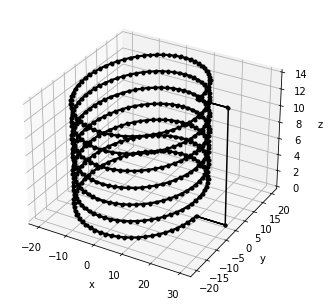

In [15]:
import CNC_thread_mill
CNC_thread_mill.plotCNC(y2)

# Моніторинг технічного стану
За допомогою агента scada1 виконується моніторинг технічного стану (під час експлуатації або випробування) різьбового з'єднання з параметром h=0,1 мм (зазор в різьбі).

In [ ]:
scada1ref=scada1.rule.remote(0.1)

 pid=10448) COM7


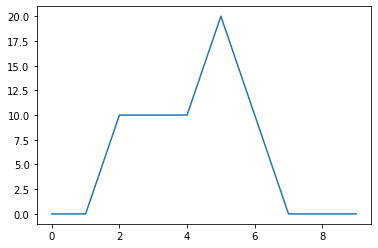

In [16]:
# виконайте цю комірку, коли rule завершить роботу
X,Y=ray.get(scada1ref)
import matplotlib.pyplot as plt
plt.plot(X,Y)
plt.show()

Робота з документом може бути ітеративною, тобто на будь-якому етапі можна вернутись до потрібних комірок, змінити дані, виконати код і отримати нові результати. Якщо потрібно завершити роботу з ray, введіть:

In [17]:
#ray.shutdown()